## **Reading the Dataset**

We're reading the folders and splitting them into **train and test set** for training purposes.

In [39]:
import os
import cv2
import time
import random
import numpy as np

import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import preprocess_input

import seaborn as sns
import matplotlib.pyplot as plt
tf.__version__, np.__version__

('2.4.1', '1.19.5')

In [40]:
# Setting random seeds to enable consistency while testing.
random.seed(5)
np.random.seed(5)
tf.random.set_seed(5)

ROOT = "../input/face-recognition-dataset/Extracted Faces/Extracted Faces"

def read_image(index):
    path = os.path.join(ROOT, index[0], index[1])
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

In [41]:
def split_dataset(directory, split=0.9):
    folders = os.listdir(directory)
    num_train = int(len(folders)*split)
    
    random.shuffle(folders)
    
    train_list, test_list = {}, {}
    
    # Creating Train-list
    for folder in folders[:num_train]:
        num_files = len(os.listdir(os.path.join(directory, folder)))
        train_list[folder] = num_files
    
    # Creating Test-list
    for folder in folders[num_train:]:
        num_files = len(os.listdir(os.path.join(directory, folder)))
        test_list[folder] = num_files  
    
    return train_list, test_list

train_list, test_list = split_dataset(ROOT, split=0.9)
print("Length of training list:", len(train_list))
print("Length of testing list :", len(test_list))

# train_list, test list contains the folder names along with the number of files in the folder.
print("\nTest List:", test_list)

Length of training list: 1191
Length of testing list : 133

Test List: {'323': 2, '1': 2, '1479': 2, '1307': 4, '1588': 46, '1447': 4, '621': 7, '1074': 4, '649': 12, '1487': 4, '616': 13, '1045': 2, '1674': 2, '591': 11, '564': 2, '925': 2, '257': 3, '66': 3, '211': 4, '226': 7, '970': 2, '911': 3, '620': 4, '342': 2, '1531': 7, '1544': 2, '1486': 6, '389': 3, '460': 3, '435': 7, '155': 2, '858': 7, '1110': 3, '124': 2, '332': 2, '881': 3, '983': 2, '912': 3, '1184': 3, '586': 2, '985': 2, '959': 2, '803': 4, '1036': 2, '775': 2, '630': 2, '1506': 2, '707': 2, '1583': 2, '768': 3, '469': 4, '237': 3, '251': 7, '848': 2, '1527': 2, '1242': 2, '1256': 8, '418': 3, '1511': 2, '1002': 3, '532': 2, '268': 3, '741': 2, '824': 14, '234': 5, '197': 2, '1587': 3, '316': 4, '1370': 3, '184': 3, '205': 12, '940': 2, '492': 2, '625': 12, '294': 2, '1296': 2, '1147': 2, '361': 3, '311': 2, '631': 15, '32': 3, '1222': 2, '91': 3, '74': 7, '695': 3, '1189': 29, '1676': 9, '1677': 3, '876': 10, '747'

### Creating Triplets

We use the train and test list to create triplets of **(anchor, postive, negative)** face data, where positive is the same person and negative is a different person than anchor.

In [42]:
def create_triplets(directory, folder_list, max_files=10):
    triplets = []
    folders = list(folder_list.keys())
    
    for folder in folders:
        path = os.path.join(directory, folder)
        files = list(os.listdir(path))[:max_files]
        num_files = len(files)
        
        for i in range(num_files-1):
            for j in range(i+1, num_files):
                anchor = (folder, f"{i}.jpg")
                positive = (folder, f"{j}.jpg")

                neg_folder = folder
                while neg_folder == folder:
                    neg_folder = random.choice(folders)
                neg_file = random.randint(0, folder_list[neg_folder]-1)
                negative = (neg_folder, f"{neg_file}.jpg")

                triplets.append((anchor, positive, negative))
            
    random.shuffle(triplets)
    return triplets

In [43]:
train_triplet = create_triplets(ROOT, train_list)
test_triplet  = create_triplets(ROOT, test_list)

print("Number of training triplets:", len(train_triplet))
print("Number of testing triplets :", len(test_triplet))

print("\nExamples of triplets:")
for i in range(5):
    print(train_triplet[i])

Number of training triplets: 9996
Number of testing triplets : 1235

Examples of triplets:
(('1308', '6.jpg'), ('1308', '7.jpg'), ('736', '0.jpg'))
(('422', '1.jpg'), ('422', '2.jpg'), ('1616', '12.jpg'))
(('1410', '3.jpg'), ('1410', '5.jpg'), ('1400', '1.jpg'))
(('1597', '3.jpg'), ('1597', '4.jpg'), ('495', '1.jpg'))
(('1580', '3.jpg'), ('1580', '4.jpg'), ('1072', '0.jpg'))


### Creating Batch-Generator

Creating a **Batch-Generator** that converts the triplets passed into batches of face-data and **preproccesses** it before returning the data into seperate lists.

**Parameters:**
- Batch_size: Batch_size of the data to return
- Preprocess: Whether to preprocess the data or not

In [44]:
def get_batch(triplet_list, batch_size=256, preprocess=True):
    batch_steps = len(triplet_list)//batch_size
    
    for i in range(batch_steps+1):
        anchor   = []
        positive = []
        negative = []
        
        j = i*batch_size
        while j<(i+1)*batch_size and j<len(triplet_list):
            a, p, n = triplet_list[j]
            anchor.append(read_image(a))
            positive.append(read_image(p))
            negative.append(read_image(n))
            j+=1
            
        anchor = np.array(anchor)
        positive = np.array(positive)
        negative = np.array(negative)
        
        if preprocess:
            anchor = preprocess_input(anchor)
            positive = preprocess_input(positive)
            negative = preprocess_input(negative)
        
        yield ([anchor, positive, negative])

### Plotting the Data

Plotting the data generated from **get_batch()** to see the results

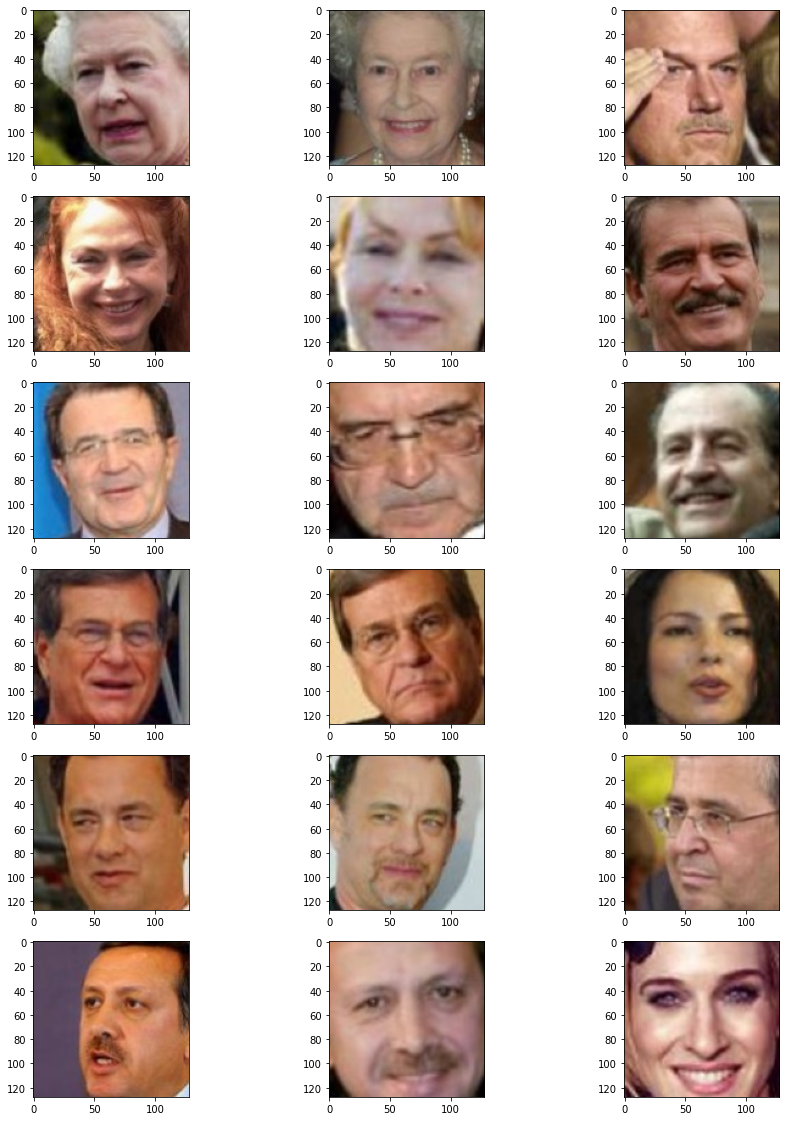

In [45]:
num_plots = 6

f, axes = plt.subplots(num_plots, 3, figsize=(15, 20))

for x in get_batch(train_triplet, batch_size=num_plots, preprocess=False):
    a,p,n = x
    for i in range(num_plots):
        axes[i, 0].imshow(a[i])
        axes[i, 1].imshow(p[i])
        axes[i, 2].imshow(n[i])
        i+=1
    break

### Classify Images

To compute the distance between the encodings of the images, we'll be using distance formula. Distance over a certain threshold to be "different" and below the threshold as "same".

In [48]:
encoder = tf.keras.applications.Xception(include_top=False, weights="imagenet")

def classify_images(face_list1, face_list2, threshold=5500):
    # Getting the encodings for the passed faces
    tensor1 = encoder.predict(face_list1).reshape(256,-1)
    tensor2 = encoder.predict(face_list2).reshape(256, -1)
    distance = np.sum(np.square(tensor1-tensor2), axis=-1)
    prediction = np.where(distance<=threshold, 0, 1)
    return prediction


Accuracy of model: 0.6796875



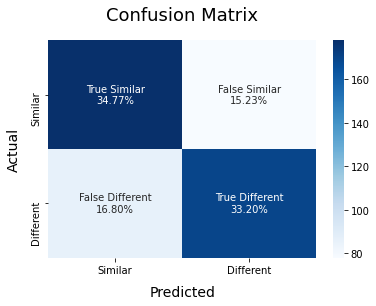

In [49]:
from sklearn.metrics import accuracy_score, confusion_matrix
def ModelMetrics(pos_list, neg_list):
    true = np.array([0]*len(pos_list)+[1]*len(neg_list))
    pred = np.append(pos_list, neg_list)
    
    # Compute and print the accuracy
    print(f"\nAccuracy of model: {accuracy_score(true, pred)}\n")
    
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(true, pred)

    categories  = ['Similar','Different']
    names = ['True Similar','False Similar', 'False Different','True Different']
    percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(names, percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)


pos_list = np.array([])
neg_list = np.array([])




for data in get_batch(test_triplet, batch_size=256):
    a, p, n = data
    pos_list = np.append(pos_list, classify_images(a, p))
    neg_list = np.append(neg_list, classify_images(a, n))
    break

ModelMetrics(pos_list, neg_list)